# CluedIn Final Task - Advanced Company Profiling and Data Validation

## Notebook Outline:
Step 0: Install Required Libraries
Step 1: Import Libraries
Step 2: Load Configuration
Step 3: Start Execution Timer
Step 4: Load Company Data
Step 5: Clean Column Names and Values
Step 6: Deduplicate Records
Step 7: Define Matching Function
Step 8: Perform Batch Matching
Step 9: Assign Results to DataFrame
Step 10: Filter and Save Unmatched and Duplicate Records
Step 11: Summary Stats
Step 12: Export Enriched Data
Step 12: Visualize Results
Step 13: Print Total Time Taken

Step 0: Install Required Libraries

In [32]:
!pip install pandas numpy matplotlib seaborn requests tqdm

Step 1: Import Libraries

In [33]:
import pandas as pd
import numpy as np
import requests
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Step 2: Load Configuration

In [34]:
config_path = r"C:\Users\kumar\Downloads\Configuration.csv"

try:
    config_df = pd.read_csv(config_path)
    config = config_df.squeeze("columns") if len(config_df.columns) == 1 else config_df.iloc[0]

    input_file = config["input_file"]
    output_file = config["output_file"]
    output_chart_dir = config["output_chart_dir"]
    batch_size = int(config["batch_size"])
    api_delay = float(config["api_delay"])
    API_BASE_URL = config["API_BASE_URL"]
    API_KEY = config["API_KEY"]

    print("Configuration loaded successfully.")
except Exception as e:
    print("Error loading configuration:", e)
    raise

Configuration loaded successfully.


Step 3: Start Execution Timer

In [35]:
start_time = time.time()

Step 4: Load Company Data

In [36]:
print("\nLoading data from:", input_file)
df = pd.read_csv(input_file)
print("Original shape:", df.shape)


Loading data from: C:\Users\kumar\Downloads\Company.csv
Original shape: (307, 55)


Step 5: Clean Column Names and Values

In [37]:
df.columns = df.columns.str.strip()
df['CompanyName'] = df['CompanyName'].astype(str).str.strip().str.title()
if 'CompanyNumber' not in df.columns:
    print("Error: 'CompanyNumber' column is missing from the dataset.")
else:
    df['CompanyNumber'] = df['CompanyNumber'].astype(str).str.strip().replace('', np.nan)

Step 6: Deduplicate Records

In [38]:
df_unique = df.drop_duplicates(subset=['CompanyName', 'RegAddress.PostCode']).copy()
duplicates = df[df.duplicated(subset=['CompanyName', 'RegAddress.PostCode'], keep=False)]  # Capture duplicate records
print("Deduplicated shape:", df_unique.shape)

Deduplicated shape: (302, 55)


Step 7: Define Matching Function

In [39]:
def match_company_name_hybrid(company_name, local_company_number=None):
    try:
        response = requests.get(
            API_BASE_URL,
            params={'q': company_name},
            auth=(API_KEY, '')
        )
        if response.status_code == 200:
            data = response.json()
            if 'items' in data and len(data['items']) > 0:
                best_match = data['items'][0]
                match_company_number = best_match.get("company_number", None)
                match_name = best_match.get("title", None)
                confidence = best_match.get("matches", {}).get("title", [0])[0]

                if local_company_number and local_company_number == match_company_number:
                    match_status = "Exact match"
                    matched = True
                elif company_name.lower() == match_name.lower():
                    match_status = "Name match only"
                    matched = True
                else:
                    match_status = "Name match only" if not local_company_number or local_company_number != match_company_number else "No match"
                    matched = match_status != "No match"

                return {
                    "matched": matched,
                    "match_status": match_status,
                    "matched_name": match_name,
                    "company_number": match_company_number,
                    "company_status": best_match.get("company_status", None),
                    "address": best_match.get("address_snippet", None),
                    "match_confidence": confidence
                }
    except Exception as e:
        print(f" Error matching '{company_name}': {e}")
    return {
        "matched": False,
        "match_status": "No match",
        "matched_name": None,
        "company_number": None,
        "company_status": None,
        "address": None,
        "match_confidence": None
    }

Step 8: Perform Batch Matching

In [40]:
print("\nStarting hybrid company matching...")
matched_results = []
for i in tqdm(range(0, len(df_unique), batch_size)):
    batch_start_time = time.time()
    batch = df_unique.iloc[i:i + batch_size]
    for _, row in batch.iterrows():
        name = row['CompanyName']
        number = row.get('CompanyNumber', None)
        # print(f" Matching: {name}") # Enable this statement if need for tracking/logs
        result = match_company_name_hybrid(name, number)
        matched_results.append(result)
        time.sleep(api_delay)
    batch_end_time = time.time()
    print(f" Processed: {i + batch_size}/{len(df_unique)} | Batch Time: {round(batch_end_time - batch_start_time, 2)}s")


Starting hybrid company matching...


  9%|█████████████▊                                                                                                                                          | 1/11 [00:15<02:38, 15.85s/it]

 Processed: 30/302 | Batch Time: 15.85s


 18%|███████████████████████████▋                                                                                                                            | 2/11 [00:31<02:23, 15.98s/it]

 Processed: 60/302 | Batch Time: 16.07s


 27%|█████████████████████████████████████████▍                                                                                                              | 3/11 [00:45<02:00, 15.06s/it]

 Processed: 90/302 | Batch Time: 13.97s


 36%|███████████████████████████████████████████████████████▎                                                                                                | 4/11 [01:02<01:49, 15.59s/it]

 Processed: 120/302 | Batch Time: 16.4s


 45%|█████████████████████████████████████████████████████████████████████                                                                                   | 5/11 [01:18<01:35, 15.91s/it]

 Processed: 150/302 | Batch Time: 16.49s


 55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6/11 [01:32<01:16, 15.22s/it]

 Processed: 180/302 | Batch Time: 13.87s


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7/11 [01:49<01:02, 15.75s/it]

 Processed: 210/302 | Batch Time: 16.84s


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8/11 [02:06<00:48, 16.02s/it]

 Processed: 240/302 | Batch Time: 16.59s


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 9/11 [02:24<00:33, 16.79s/it]

 Processed: 270/302 | Batch Time: 18.47s


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 10/11 [02:39<00:16, 16.09s/it]

 Processed: 300/302 | Batch Time: 14.54s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:40<00:00, 14.55s/it]

 Processed: 330/302 | Batch Time: 0.94s


Step 9: Assign Results to DataFrame

In [41]:
print("\nAssigning matched results...")
df_unique["Matched"] = ["Yes" if res["matched"] else "No" for res in matched_results]
df_unique["MatchStatus"] = [res["match_status"] for res in matched_results]
df_unique["MatchedName"] = [res["matched_name"] for res in matched_results]
df_unique["MatchedCompanyNumber"] = [res["company_number"] for res in matched_results]
df_unique["CompanyStatus"] = [res["company_status"] for res in matched_results]
df_unique["AddressSnippet"] = [res["address"] for res in matched_results]
df_unique["MatchConfidence"] = [res["match_confidence"] for res in matched_results]


Assigning matched results...


Step 10: Filter and Save Unmatched and Duplicate Records

In [42]:
unmatched = df_unique[df_unique["Matched"] == "No"]
print(f"Unmatched records count: {unmatched.shape[0]}")
downloads_folder = r'C:\Users\kumar\Downloads'
duplicates_file = os.path.join(downloads_folder, 'duplicate_records.csv')
unmatched_file = os.path.join(downloads_folder, 'unmatched_records.csv')
duplicates.to_csv(duplicates_file, index=False)
unmatched.to_csv(unmatched_file, index=False)
print("Duplicate records saved to:", duplicates_file)
print("Unmatched records saved to:", unmatched_file)

Unmatched records count: 1
Duplicate records saved to: C:\Users\kumar\Downloads\duplicate_records.csv
Unmatched records saved to: C:\Users\kumar\Downloads\unmatched_records.csv


Step 11: Summary Stats

In [43]:
print("\nMatching Summary:")
print(df_unique["Matched"].value_counts())
print("\nMatch Status Breakdown:")
match_stats = df_unique["MatchStatus"].value_counts(normalize=True).apply(lambda x: f"{x:.2%}")
print(match_stats)


Matching Summary:
Matched
Yes    301
No       1
Name: count, dtype: int64

Match Status Breakdown:
MatchStatus
Exact match        92.38%
Name match only     7.28%
No match            0.33%
Name: proportion, dtype: object


Step 12: Export Enriched Data

In [44]:
print("\nSaving enriched results...")
df_unique.to_csv(output_file, index=False)
print("File saved:", output_file)


Saving enriched results...
File saved: C:\Users\kumar\Downloads\enriched_companies_output.csv


Step 12: Visualise Results


Visualising match results and saving charts...


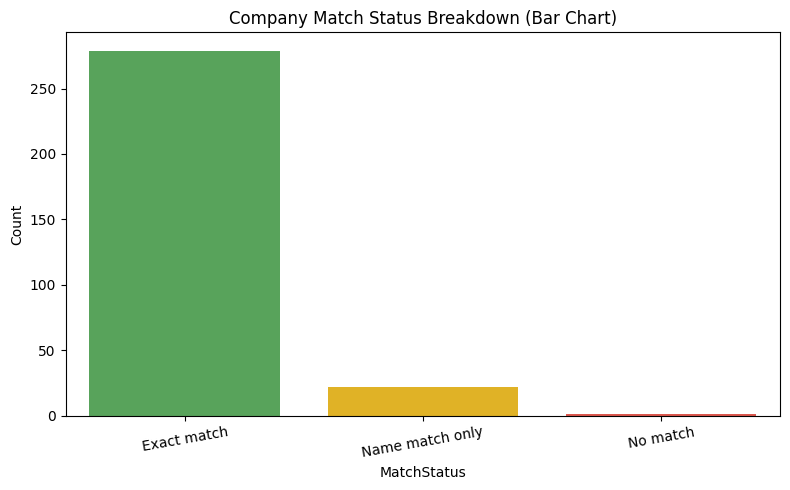

Bar chart saved to: C:\Users\kumar\Downloads\charts\company_match_bar_chart.png


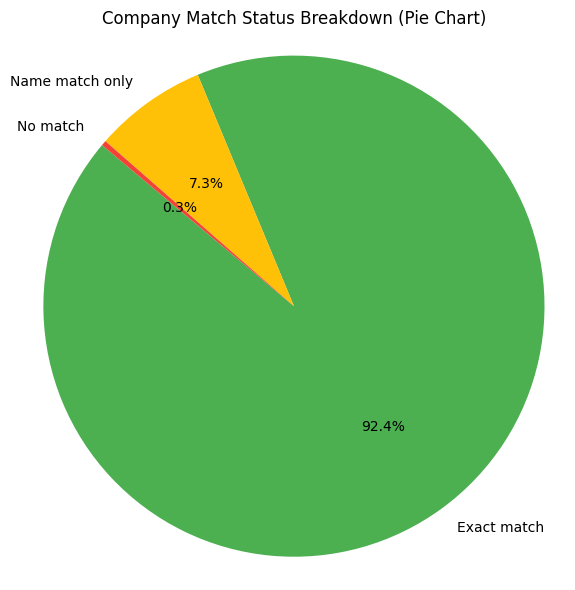

Pie chart saved to: C:\Users\kumar\Downloads\charts\company_match_pie_chart.png


In [45]:
print("\nVisualising match results and saving charts...")

status_colors = {
    "Exact match": "#4CAF50",
    "Name match only": "#FFC107",
    "No match": "#F44336"
}

plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_unique,
    x="MatchStatus",
    hue="MatchStatus",
    palette=status_colors,
    legend=False
)
plt.title("Company Match Status Breakdown (Bar Chart)")
plt.ylabel("Count")
plt.xticks(rotation=10)
plt.tight_layout()

bar_chart_path = os.path.join(output_chart_dir, "company_match_bar_chart.png")
plt.savefig(bar_chart_path)
plt.show()
print("Bar chart saved to:", bar_chart_path)

plt.figure(figsize=(6, 6))
match_counts = df_unique["MatchStatus"].value_counts()
plt.pie(
    match_counts,
    labels=match_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=[status_colors[status] for status in match_counts.index]
)
plt.title("Company Match Status Breakdown (Pie Chart)")
plt.axis('equal')
plt.tight_layout()

pie_chart_path = os.path.join(output_chart_dir, "company_match_pie_chart.png")
plt.savefig(pie_chart_path)
plt.show()
print("Pie chart saved to:", pie_chart_path)

Step 13: Print Total Time Taken

In [46]:
end_time = time.time()
print(f"\nTotal time taken: {round(end_time - start_time, 2)} seconds")


Total time taken: 161.37 seconds
